# Toxicity Classification:


**dataset link:** https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification<br><br>

**Problem Statement:** Given a comment made by the user, predict the toxicity of the comment.<br><br>



- We have one single csv file for training and one cvs file to test.
- Columns in train data:
    - Comment_text: This is the data in string format which we have to use to find the toxicity.
    - target: Target values which are to be predicted (has values between 0 and 1)
    - Data also has additional toxicity subtype attributes: (Model does not have to predict these)
        - severe_toxicity
        - obscene
        - threat
        - insult
        - identity_attack
        - sexual_explicit

    -a subset of comments have been labelled with a variety of identity attributes, representing the identities that are mentioned in the comment. The columns corresponding to identity attributes are listed below. Only identities with more than 500 examples in the test set (combined public and private) will be included in the evaluation calculation. These identities are shown in bold.

        - male
        - female
        - transgender
        - other_gender
        - heterosexual
        - homosexual_gay_or_lesbian
        - bisexual
        - other_sexual_orientation
        - christian
        - jewish
        - muslim
        - hindu
        - buddhist
        - atheist
        - other_religion
        - black
        - white
        - asian
        - latino
        - other_race_or_ethnicity
        - physical_disability
        - intellectual_or_learning_disability
        - psychiatric_or_mental_illness
        - other_disability


#### Example Datapoints and Labels:<br>

**Comment:** i'm a white woman in my late 60's and believe me, they are not too crazy about me either!!<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 1.0, white: 1.0 (all others 0.0)

**Comment:** Why would you assume that the nurses in this story were women?<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 0.8 (all others 0.0)

**Comment:** Continue to stand strong LGBT community. Yes, indeed, you'll overcome and you have.<br><r>

- Toxicity Labels: All 0.0
- Identity Mention Labels: homosexual_gay_or_lesbian: 0.8, bisexual: 0.6, transgender: 0.3 (all others 0.0)



#### Machine Learning Problem:<br>

We have to predict the toxicity level(target attribute). The values range from 0 to 1 inclusive. This is a regression problem. It can also be treated as a classification problem if we take every value below 0.5 to be non-toxic and above it to be toxic, we would then get a binary classification problem.



#### Performance Metric:

The competition will use ROC_AUC as the metric after converting the numeric target variable into a categorical variable by using a threshold of 0.5. Any comment above 0.5 will be assumed to be toxic and below it non-toxic. For our training and evaluation we will use the MSE(Mean Squared Error).<br>
More on evaluation: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation



####  Machine Learning Objectives and Constraints:<br>

**Objectives:** Predict the toxicity of a comment made by the user. (0 -> not toxic, 1 -> highest toxicity level)

**Constraints:**
- The model should be fast to predict the toxicity rating.
- Interpretability is not needed.

Unzip File from google drive

In [1]:
# !unzip -u '/content/drive/MyDrive/Colab Notebooks/datasets/Toxic Comment/train.csv (2).zip'
# !unzip -u '/content/drive/MyDrive/Colab Notebooks/datasets/Toxic Comment/test.csv.zip'

Importing Libraries:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import SnowballStemmer, PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import SGDRegressor 
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')


Read train and test data

In [3]:
df_train = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
df_test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

In [4]:
df_train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


Shape of train and test

In [5]:
print("train data shape : ", df_train.shape)
print("Test data shape : ", df_test.shape)

train data shape :  (1804874, 45)
Test data shape :  (97320, 2)


**Null value**

In [6]:
pd.DataFrame(df_train.isnull().sum()/ df_train.shape[0])

,0
id,0.000000
target,0.000000
comment_text,0.000000
severe_toxicity,0.000000
obscene,0.000000
identity_attack,0.000000
insult,0.000000
threat,0.000000
asian,0.775536
atheist,0.775536


There are lot null values but we don't care we only care about that all, comment_text and target

**Exploratory data analysis**

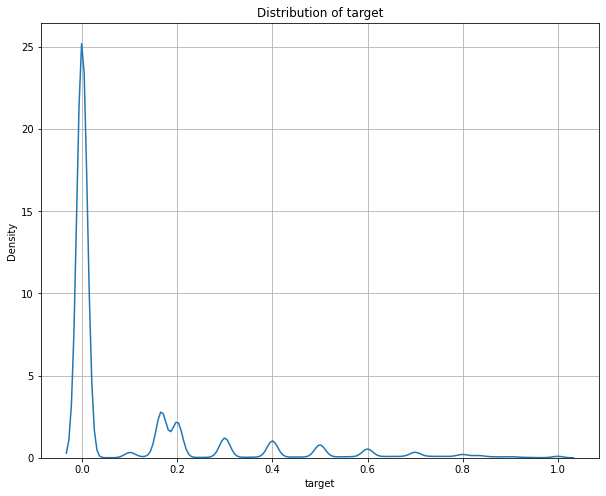

In [7]:
plt.figure(figsize=(10, 8))
sns.distplot(df_train['target'], kde=True, hist=False)
plt.title("Distribution of target")
plt.grid()
plt.show()

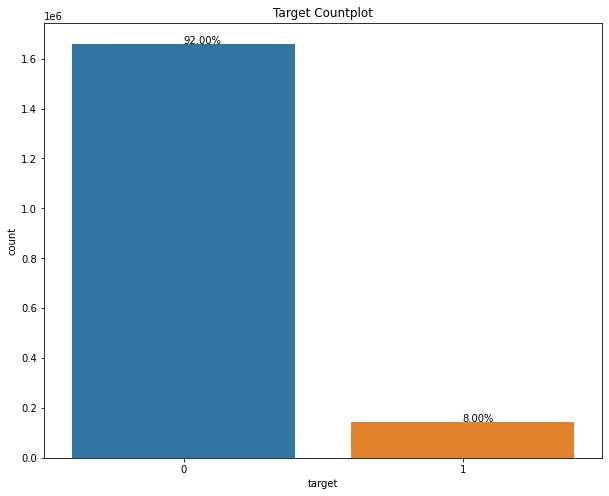

In [8]:
data = df_train['target'].apply(lambda x: 1 if x>=0.5 else 0)
total = float(len(data))


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(data)
plt.title('Target Countplot')

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.0, height+4, '{:1.2f}%'.format(100*height/total))


Our data is unbalanced. 

there is only 8% non-toxic comment and rest are toxic comment

In [9]:
df_train.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

Draw distplot of features

In [10]:
def distplot_feature(features,title, data):
  plt.figure(figsize=(10, 8))
  plt.title(title)
  for feature in features:
    sns.distplot(data[feature], kde=True, hist=False, label=feature)
  plt.legend()
  plt.xlabel(" ")
  plt.show()

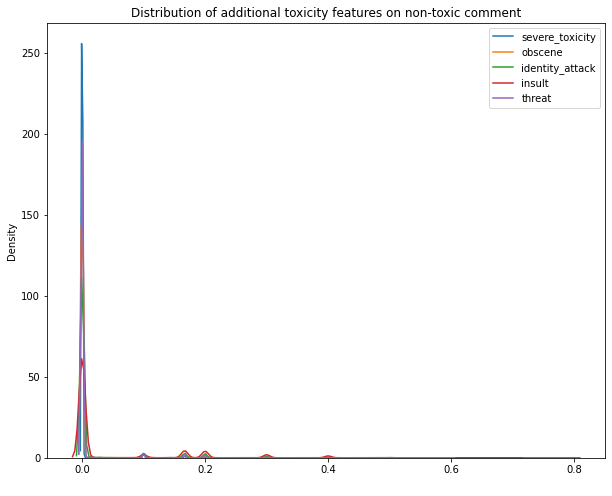

In [11]:
features = [ 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat' ]

distplot_feature(features, "Distribution of additional toxicity features on non-toxic comment" ,df_train[df_train['target']<0.5])

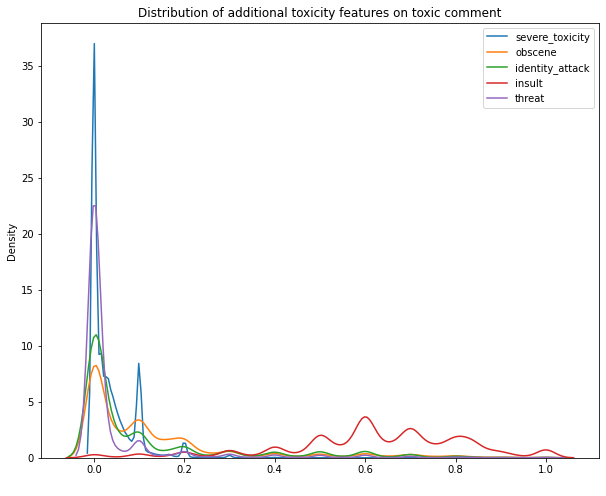

In [12]:
features = [ 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat' ]

distplot_feature(features, "Distribution of additional toxicity features on toxic comment" ,df_train[df_train['target']>0.5])

Additional toxicity features

*   severe_toxicity
*   obscene
*   identity_attack
*   insult
*   threat

Find nature of comment data

In [13]:
def comment_type(data):
  data = [ data['severe_toxicity'], data['obscene'], data['identity_attack'], data['insult'], data['threat'] ]
  data = np.argmax(data)
  if data == 0: 
    return 'severe_toxicity'
  elif data == 1:
    return 'obscene'
  elif data == 2:
    return 'identity_attack'
  elif data == 3:
    return 'insult'
  else:
    return 'threat'

Percentage of type of toxicity in additional features

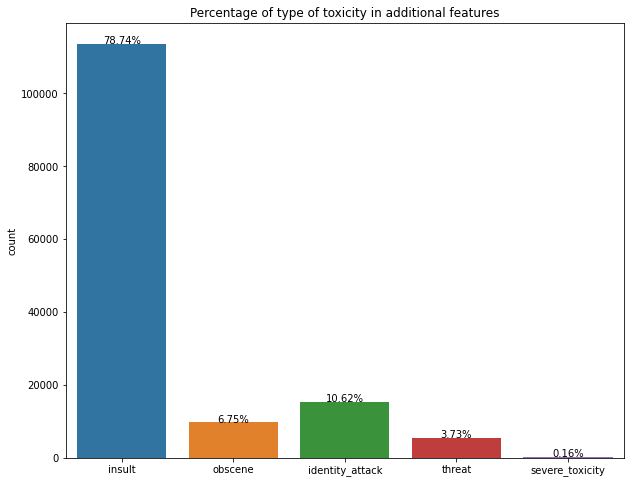

In [14]:
data = df_train[df_train['target']>=0.5].apply(comment_type, axis=1)

total = float(len(data))
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(data)
plt.title("Percentage of type of toxicity in additional features")
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')

from 8% toxic comment, 78% of the toxic comment made are insults, 6.75% are obscene, 10.62% are identity_attack, 3.73% are threat, 0.16% are severe toxicity.

**Gender attributes**

male

female

homosexual_gay_or_lesbian

bisexual

heterosexual

other_gender 

transgender

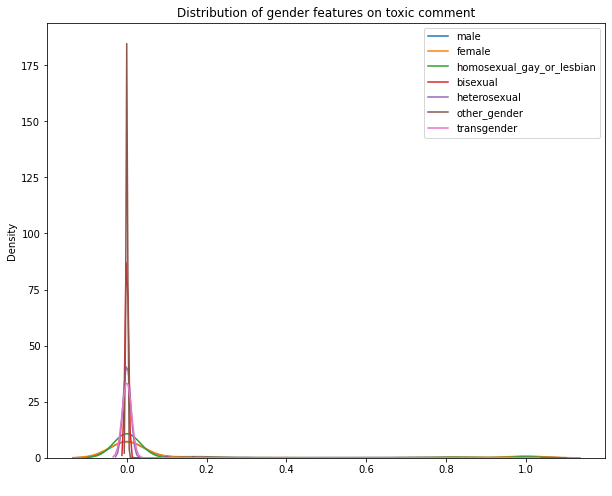

In [15]:
features = ['male', 'female', 'homosexual_gay_or_lesbian', 'bisexual', 'heterosexual', 'other_gender', 'transgender']
distplot_feature(features, "Distribution of gender features on toxic comment", df_train[df_train['target'] > 0.5].dropna(how='any', axis=0))

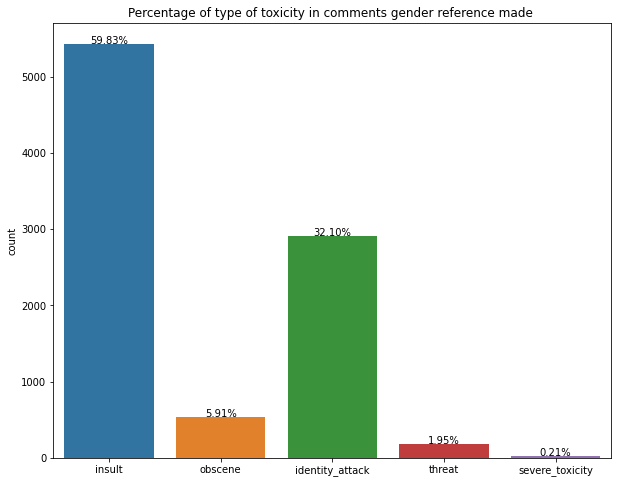

In [16]:
data = (df_train['male'] > 0.5) | (df_train['female'] > 0.5) | (df_train['homosexual_gay_or_lesbian'] > 0.5) | (df_train['bisexual'] > 0.5) | (df_train['heterosexual'] > 0.5) | (df_train['other_gender'] > 0.5) | (df_train['transgender'] > 0.5)
data = df_train[data]
data = data[data['target'] > 0.5]
data = data.apply(comment_type, axis=1)

total = len(data)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(data)
plt.title("Percentage of type of toxicity in comments gender reference made ")
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')

We see from the plot that the toxic comments where sexual orientation references are made are mostly used for insult and identity attacks.

In [17]:
df_train.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

**Region features**


*   hindu
*   jewish
*   latino
*   muslim
*   atheist
*   other_religion

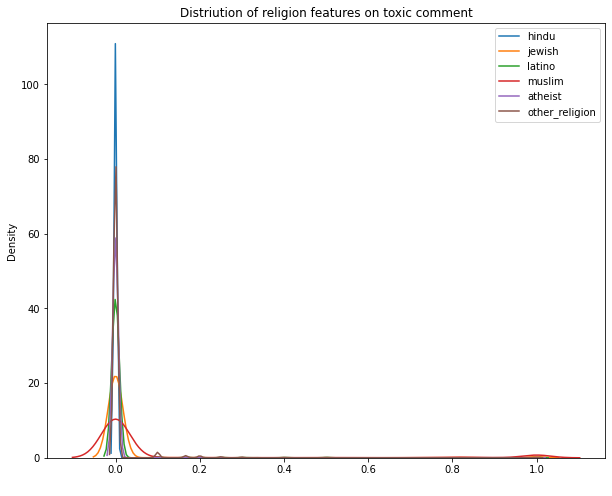

In [18]:
features = ['hindu', 'jewish', 'latino', 'muslim', 'atheist', 'other_religion']
distplot_feature(features, "Distriution of religion features on toxic comment", df_train[df_train['target'] > 0.5])

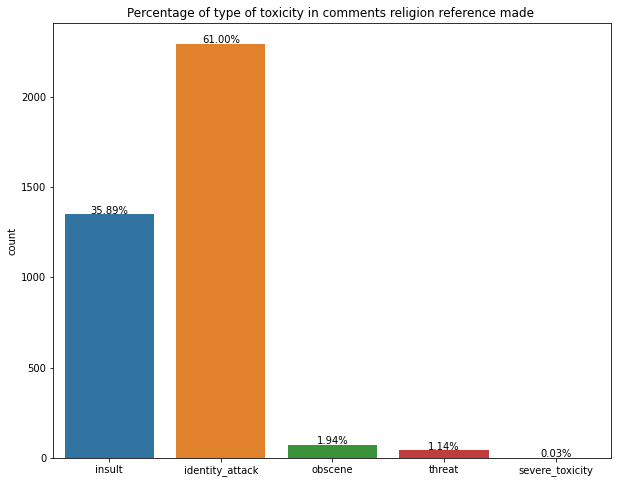

In [19]:
data = (df_train['hindu'] > 0.5) | (df_train['jewish'] > 0.5) | (df_train['latino'] > 0.5) | (df_train['muslim'] > 0.5) | (df_train['atheist'] > 0.5) | (df_train['other_religion'] > 0.5) 
data = df_train[data]
data = data[data['target'] > 0.5]
data = data.apply(comment_type, axis=1)

total = len(data)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(data)
plt.title("Percentage of type of toxicity in comments religion reference made ")
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')

We see from the plot that the toxic comments where religion references are made are mostly used for identity attacks and insults.

Features generated by users feedback

*   funny
*   sad
*   wow
*   likes
*   disagree

In [20]:
def count_plot(feature, title, data):
  data = data[feature]
  fig, ax = plt.subplots(1, 1, figsize=(16, 5))
  total = float(len(data))
  sns.countplot(data, order=data.value_counts().index[:15])
  plt.title(title)
  for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, height+3, '{:1.2f}%'.format(100*height/total))

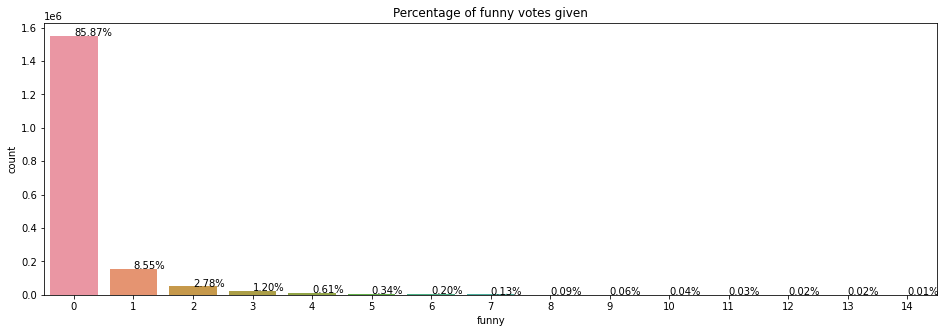

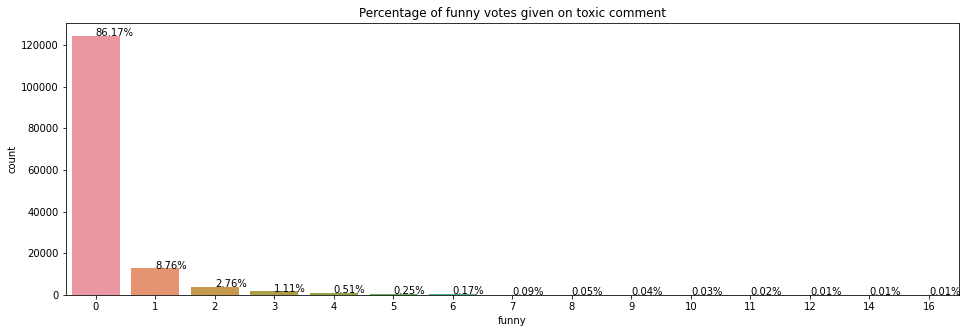

In [21]:
count_plot('funny', "Percentage of funny votes given", df_train)
count_plot('funny', "Percentage of funny votes given on toxic comment", df_train[df_train['target'] >= 0.5])

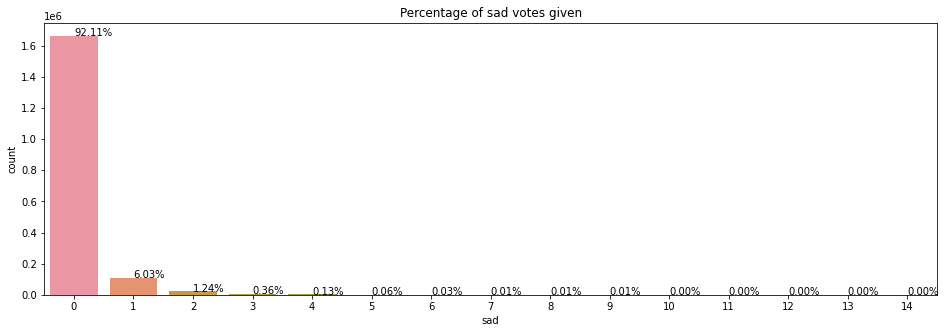

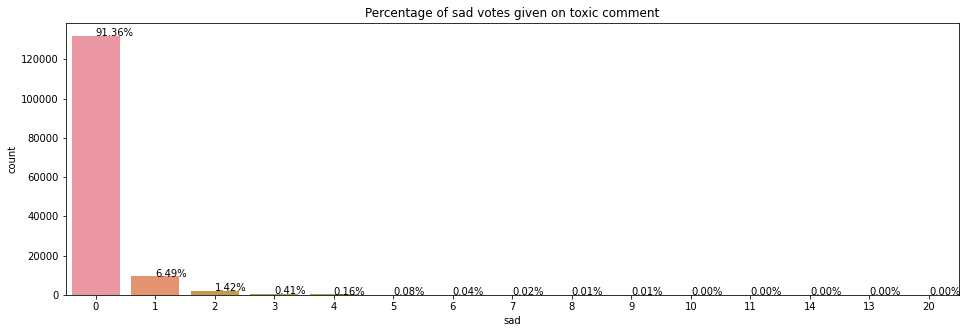

In [22]:
count_plot('sad', "Percentage of sad votes given", df_train)
count_plot('sad', "Percentage of sad votes given on toxic comment", df_train[df_train['target'] >= 0.5])

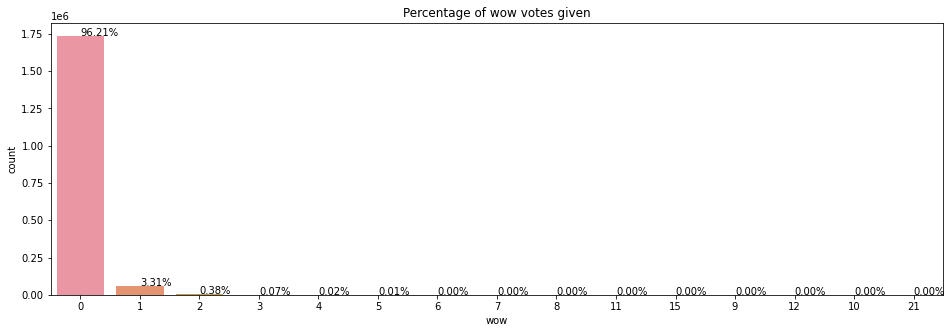

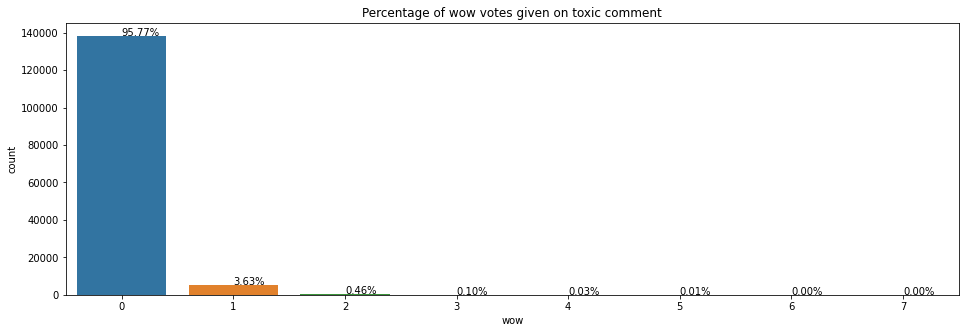

In [23]:
count_plot('wow', "Percentage of wow votes given", df_train)
count_plot('wow', "Percentage of wow votes given on toxic comment", df_train[df_train['target'] >= 0.5])

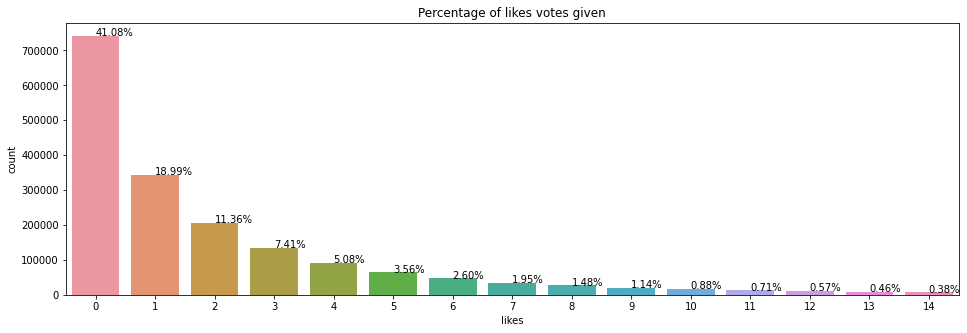

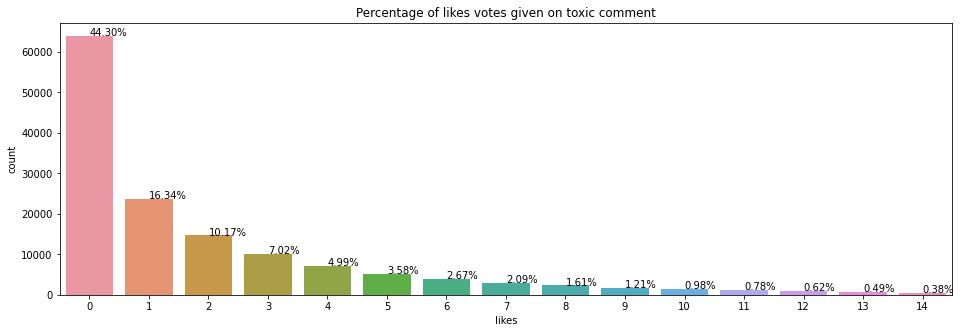

In [24]:
count_plot('likes', "Percentage of likes votes given", df_train)
count_plot('likes', "Percentage of likes votes given on toxic comment", df_train[df_train['target'] >= 0.5])

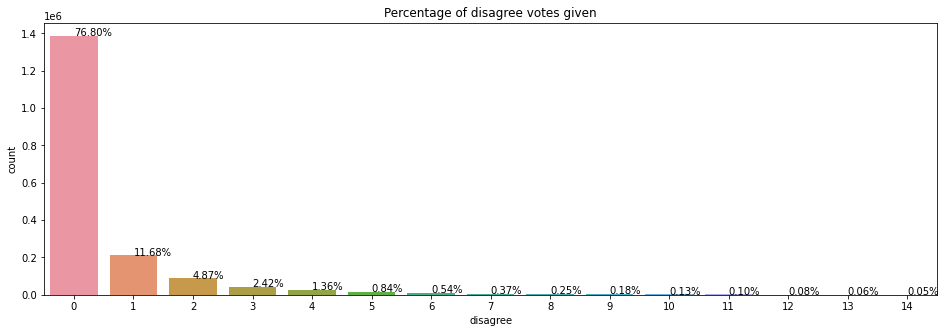

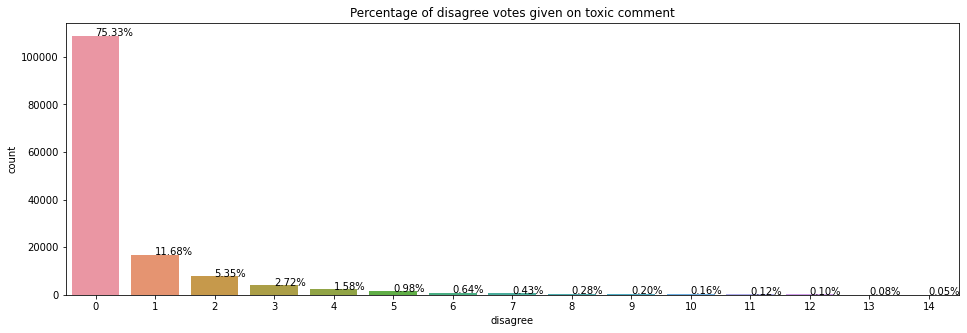

In [25]:
count_plot('disagree', "Percentage of disagree votes given", df_train)
count_plot('disagree', "Percentage of disagree votes given on toxic comment", df_train[df_train['target'] >= 0.5])

**Wordcloud of comment text**

In [26]:
def show_wordcloud(data, title=None):
  wordcloud = WordCloud(
      background_color = 'white',
      stopwords = set(STOPWORDS),
      max_words = 50,
      scale = 5,
      random_state = 1
  ).generate(str(data))

  fig = plt.figure(figsize=(10, 10))
  plt.axis('off')
  if title:
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)

  plt.imshow(wordcloud)
  plt.show()

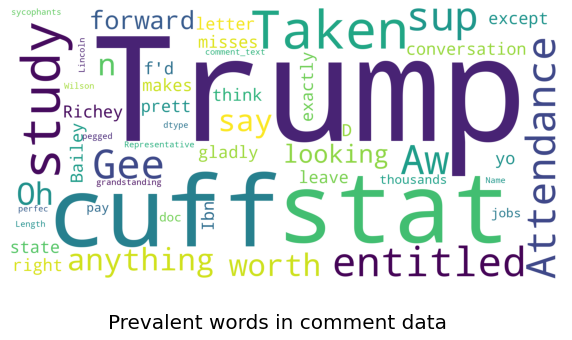

In [27]:
show_wordcloud(df_train['comment_text'].sample(20000), title="Prevalent words in comment data")

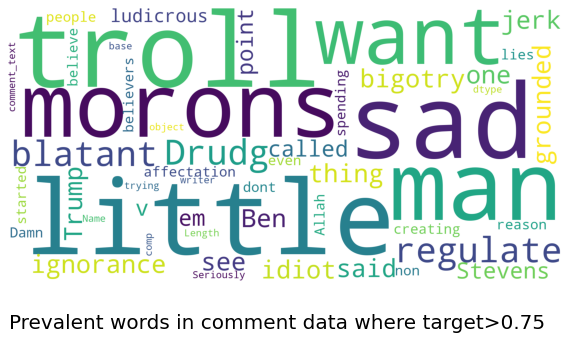

In [28]:
show_wordcloud(df_train[df_train['target'] > 0.75]['comment_text'].sample(20000), title="Prevalent words in comment data where target>0.75")

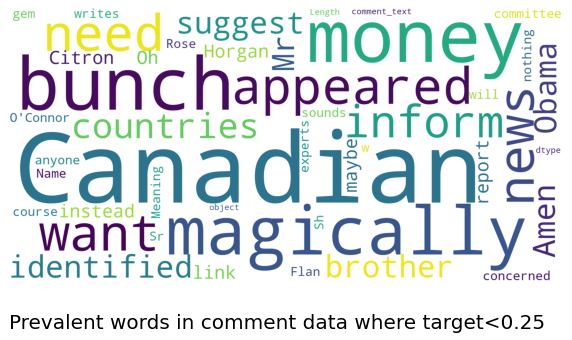

In [29]:
show_wordcloud(df_train[df_train['target'] < 0.25]['comment_text'].sample(20000), title="Prevalent words in comment data where target<0.25")

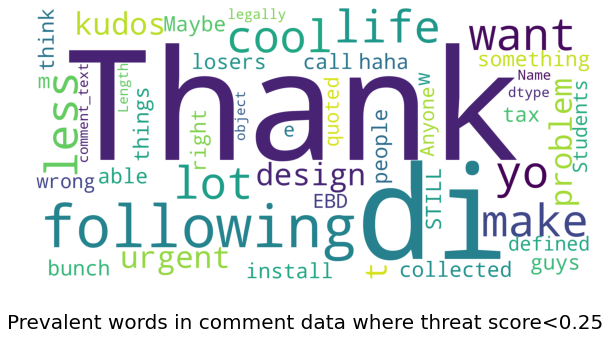

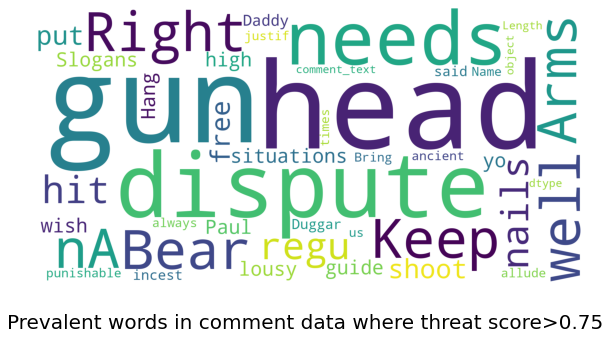

In [30]:
show_wordcloud(df_train[df_train['threat'] < 0.25]['comment_text'], title="Prevalent words in comment data where threat score<0.25")
show_wordcloud(df_train[df_train['threat'] > 0.75]['comment_text'], title="Prevalent words in comment data where threat score>0.75")

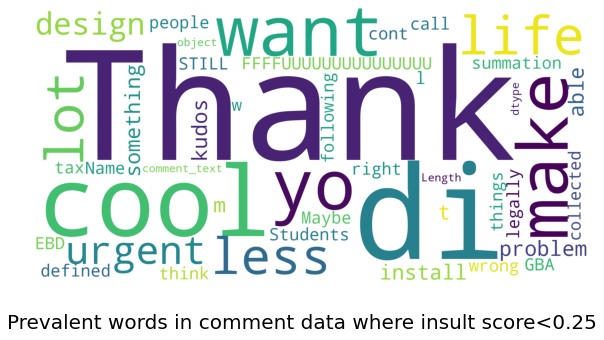

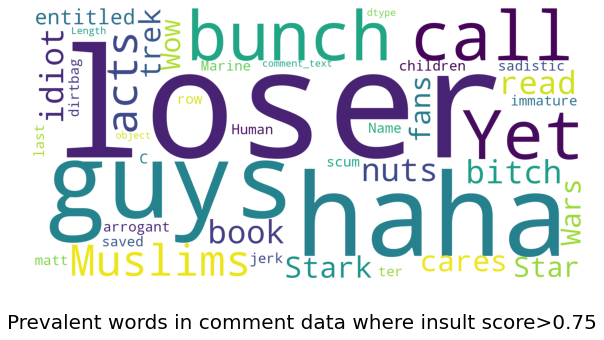

In [31]:
show_wordcloud(df_train[df_train['insult'] < 0.25]['comment_text'], title="Prevalent words in comment data where insult score<0.25")
show_wordcloud(df_train[df_train['insult'] > 0.75]['comment_text'], title="Prevalent words in comment data where insult score>0.75")

**Preprocess text**

In [32]:
nltk.download('stopwords')
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

def preprocess(str):
  str = str.lower()
  str = re.sub('[^A-Za-z0-9]+', ' ', str)   # remove other words
  words = str.split()                       # split string
  new_str = []
  for word in words:
    if word not in stop_words:
      new_str.append(stemmer.stem(word)) 
  new_str = ' '.join(new_str)
  return new_str


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocess text of train comment_text

In [33]:
%%time
df_train['preprocessed_text'] = df_train['comment_text'].apply(preprocess)

CPU times: user 13min 40s, sys: 1.13 s, total: 13min 41s
Wall time: 13min 43s


In [34]:
df_train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read realli great ...
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxieti induc k...
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudo take impress
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,someth abl instal site releas
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha guy bunch loser


Preprocess on train comment_text

In [35]:
%%time
df_test['preprocessed_text'] = df_test['comment_text'].apply(preprocess)

CPU times: user 43.8 s, sys: 58.7 ms, total: 43.9 s
Wall time: 44.5 s


In [36]:
df_test.head()

,id,comment_text,preprocessed_text
0,7097320,[ Integrity means that you pay your debts.]\n\...,integr mean pay debt appli presid trump
1,7097321,This is malfeasance by the Administrator and t...,malfeas administr board wast money
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,rmiller101 spoken like true elitist look bud a...
3,7097323,"Paul: Thank you for your kind words. I do, in...",paul thank kind word inde strong belief hide b...
4,7097324,Sorry you missed high school. Eisenhower sent ...,sorri miss high school eisenhow sent troop vie...


Split data into train and validation

In [37]:
message = df_train['preprocessed_text']
target = df_train['target'] 

train_message, val_message, train_target , val_target = train_test_split(message, target, test_size=0.1)

print("train_message : ", train_message.shape)
print("train_target : ", train_target.shape)
print("val_message : ", val_message.shape)
print("val_target : ", val_target.shape)

train_message :  (1624386,)
train_target :  (1624386,)
val_message :  (180488,)
val_target :  (180488,)


Preprocess on test comment text

In [38]:
test_message = df_test['preprocessed_text']

print("test_message : ", test_message.shape)

test_message :  (97320,)


Convert data into pickle file so we don't need to run entire code for next time

In [39]:
# train_message.to_pickle('train_message.pkl')
# train_target.to_pickle('train_target.pkl')
# val_message.to_pickle('val_message.pkl')
# val_target.to_pickle('val_target.pkl')
# test_message.to_pickle('test_message.pkl')

Copy pickle files in google drive

In [40]:
# !cp '/content/train_message.pkl' '/content/drive/MyDrive/Colab Notebooks/datasets/Toxic Comment'
# !cp '/content/train_target.pkl' '/content/drive/MyDrive/Colab Notebooks/datasets/Toxic Comment'
# !cp '/content/val_message.pkl' '/content/drive/MyDrive/Colab Notebooks/datasets/Toxic Comment'
# !cp '/content/val_target.pkl' '/content/drive/MyDrive/Colab Notebooks/datasets/Toxic Comment'
# !cp '/content/test_message.pkl' '/content/drive/MyDrive/Colab Notebooks/datasets/Toxic Comment'

Read pickle file from google drive

In [41]:
# train_message = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/datasets/Toxic Comment/train_message.pkl')
# train_target = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/datasets/Toxic Comment/train_target.pkl')
# val_message = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/datasets/Toxic Comment/val_message.pkl')
# val_target = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/datasets/Toxic Comment/val_target.pkl')
# test_message = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/datasets/Toxic Comment/test_message.pkl')

**Count Vectorizer**

Convert text data into numeric using count vectorizer

In [42]:
%%time
cv = CountVectorizer(max_features = 30000, ngram_range =(1, 2) )
train_message_count = cv.fit_transform(train_message)
val_message_count = cv.transform(val_message)
test_message_count = cv.transform(test_message)

CPU times: user 2min 58s, sys: 4.17 s, total: 3min 2s
Wall time: 3min 4s


**SGDRegressor with hyper parameter**

In [43]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
train_errors = []
val_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(train_message_count, train_target) # Train
        
        preds = model.predict(train_message_count) # Get predictions
        err = mean_squared_error(train_target, preds) # Calculate error on trainset
        train_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(val_message_count) # Get predictions on CV set
        err = mean_squared_error(val_target, preds) # Calculate error on cv set
        val_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*20)

1e-05 l1 :
Mean Squared Error on train set:  0.029260614732012687
Mean Squared Error on cv set:  0.023234624179997408
********************
1e-05 l2 :
Mean Squared Error on train set:  0.7043415242911872
Mean Squared Error on cv set:  0.052284407283035864
********************
0.0001 l1 :
Mean Squared Error on train set:  0.024465756323192082
Mean Squared Error on cv set:  0.024452418810169917
********************
0.0001 l2 :
Mean Squared Error on train set:  0.09500114103493439
Mean Squared Error on cv set:  0.025992665016480013
********************
0.001 l1 :
Mean Squared Error on train set:  0.03143620886759293
Mean Squared Error on cv set:  0.03140873563372833
********************
0.001 l2 :
Mean Squared Error on train set:  0.023385605124194277
Mean Squared Error on cv set:  0.023463959263927577
********************
0.01 l1 :
Mean Squared Error on train set:  0.038848323943605455
Mean Squared Error on cv set:  0.038753407126944105
********************
0.01 l2 :
Mean Squared Error on

Best_model

In [44]:
preds = best_model.predict(train_message_count) # Get predictions
err = mean_squared_error(train_target, preds) # Calculate error on trainset
print("Mean Squared Error on train set: ", err)
        
preds = best_model.predict(val_message_count) # Get predictions on CV set
err = mean_squared_error(val_target, preds) # Calculate error on cv set
print("Mean Squared Error on cv set: ", err)

Mean Squared Error on train set:  0.029260614732012687
Mean Squared Error on cv set:  0.023234624179997408


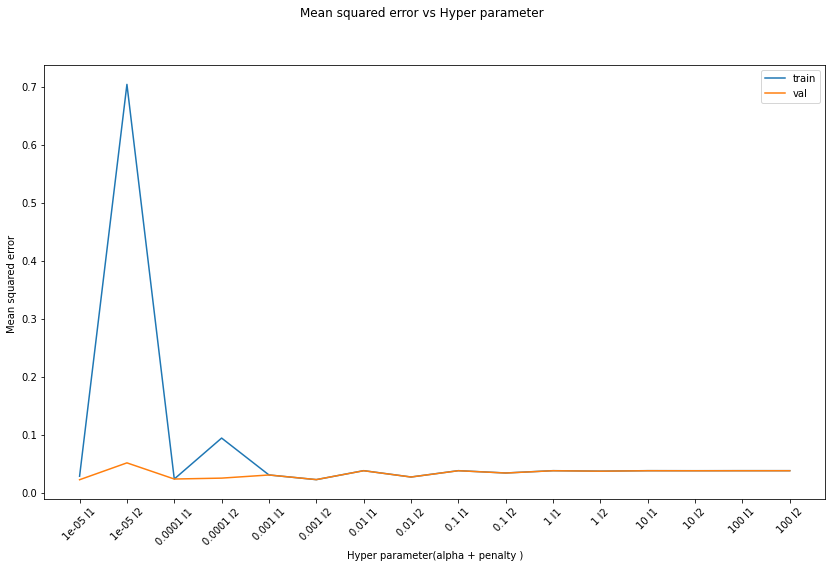

In [45]:
plt.figure(figsize=(14, 8))
plt.plot(range(len(alpha) * len(penalty) ), train_errors)
plt.plot(range(len(alpha) * len(penalty)), val_errors)
plt.suptitle("Mean squared error vs Hyper parameter")
plt.legend(['train', 'val'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyper parameter(alpha + penalty )')
plt.ylabel("Mean squared error ")
plt.show()

Coefficient of some feature

In [46]:
feat_names = cv.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.424346
stupid,0.359201
moron,0.315926
pathet,0.300723
crap,0.287255
ass,0.271828
hypocrit,0.271459
scum,0.266975
jerk,0.265957
shit,0.265498


**Decision tree hyper parameter**

In [47]:
max_depth = [3, 5, 7]
min_samp = [10, 100, 500, 1000]
train_errors = []
val_errors = []
xticks = []
best_model = None
best_error = 10

for d in max_depth:
  for s in min_samp:
    dt = DecisionTreeRegressor(max_depth = d, min_samples_leaf = s)
    dt.fit(train_message_count, train_target)

    pred = dt.predict(train_message_count) 
    xticks.append(str(d) + ' ' + str(s))
    print("max_depth : ", d, "  min_samples : ", s)
    error = mean_squared_error(pred, train_target)
    print("Train mse : ", error)
    train_errors.append(error)

    pred = dt.predict(val_message_count) 
    error = mean_squared_error(pred, val_target)
    print("val mse : ", error)
    val_errors.append(error)

    if error < best_error:
      best_model = dt
      best_error = error
      print('*'*30)

max_depth :  3   min_samples :  10
Train mse :  0.033098497584825415
val mse :  0.033177054088659674
******************************
max_depth :  3   min_samples :  100
Train mse :  0.03309849758482542
val mse :  0.03317705408865967
******************************
max_depth :  3   min_samples :  500
Train mse :  0.03309936349815183
val mse :  0.03317569609742494
******************************
max_depth :  3   min_samples :  1000
Train mse :  0.03310053533471853
val mse :  0.03317658443375903
max_depth :  5   min_samples :  10
Train mse :  0.03201488461001047
val mse :  0.032161989477979075
******************************
max_depth :  5   min_samples :  100
Train mse :  0.03201709062781426
val mse :  0.03215778599096811
******************************
max_depth :  5   min_samples :  500
Train mse :  0.0320256299398356
val mse :  0.032156861249637306
******************************
max_depth :  5   min_samples :  1000
Train mse :  0.03204270873299574
val mse :  0.03214636600143908
***********

Best decison tree model 

In [48]:
preds = best_model.predict(train_message_count) # Get predictions
err = mean_squared_error(train_target, preds) # Calculate error on trainset
print("Mean Squared Error on train set: ", err)
        
preds = best_model.predict(val_message_count) # Get predictions on CV set
err = mean_squared_error(val_target, preds) # Calculate error on cv set
print("Mean Squared Error on cv set: ", err)

Mean Squared Error on train set:  0.031029783047165863
Mean Squared Error on cv set:  0.031080850081235335


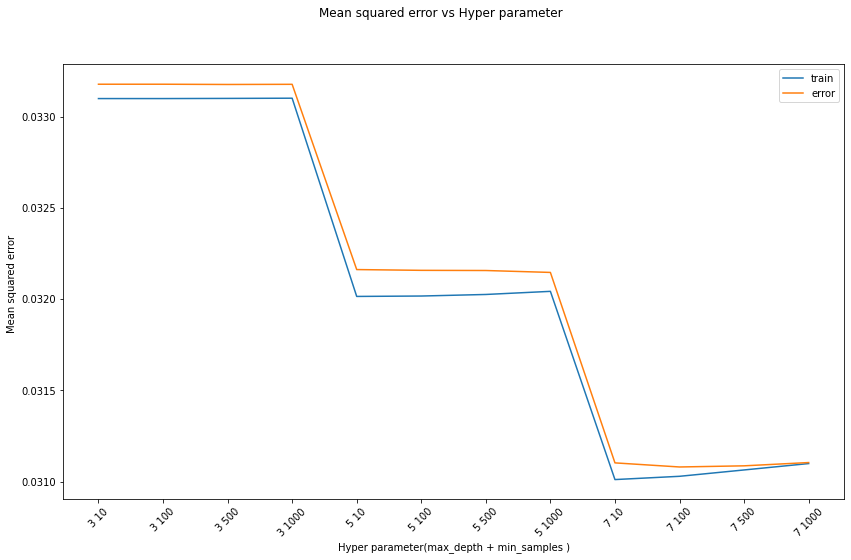

In [49]:
plt.figure(figsize=(14, 8))
plt.plot(range(len(max_depth) * len(min_samp) ), train_errors)
plt.plot(range(len(max_depth) * len(min_samp)), val_errors)
plt.suptitle("Mean squared error vs Hyper parameter")
plt.legend(['train', 'error'])
plt.xticks(range(len(max_depth) * len(min_samp)), xticks, rotation=45)
plt.xlabel('Hyper parameter(max_depth + min_samples )')
plt.ylabel("Mean squared error ")
plt.show()

In [50]:
feat_names = cv.get_feature_names()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.397179
idiot,0.263618
pathet,0.069607
fool,0.068259
moron,0.063035
white,0.058718
hypocrit,0.054737
racist,0.005745
would,0.004026
one,0.003706


Convert text to numeric features using TfIdf vectorizer

In [51]:
%%time
tfidf = TfidfVectorizer(max_features = 30000, ngram_range =(1, 2) )
train_message_tfidf = tfidf.fit_transform(train_message)
val_message_tfidf = tfidf.transform(val_message)
test_message_tfidf = tfidf.transform(test_message)

CPU times: user 3min 4s, sys: 4.18 s, total: 3min 8s
Wall time: 3min 9s


**SGDRegressor hyper parameter**

In [52]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
train_errors = []
val_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(train_message_tfidf, train_target) # Train
        
        preds = model.predict(train_message_tfidf) # Get predictions
        err = mean_squared_error(train_target, preds) # Calculate error on trainset
        train_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(val_message_tfidf) # Get predictions on CV set
        err = mean_squared_error(val_target, preds) # Calculate error on cv set
        val_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*20)

1e-05 l1 :
Mean Squared Error on train set:  0.02425228978260838
Mean Squared Error on cv set:  0.024205369529222236
********************
1e-05 l2 :
Mean Squared Error on train set:  0.023313194856301823
Mean Squared Error on cv set:  0.023324606373848766
********************
0.0001 l1 :
Mean Squared Error on train set:  0.0292946148514558
Mean Squared Error on cv set:  0.029217317094401195
********************
0.0001 l2 :
Mean Squared Error on train set:  0.024470668939022517
Mean Squared Error on cv set:  0.024469478436924687
********************
0.001 l1 :
Mean Squared Error on train set:  0.03826866422285058
Mean Squared Error on cv set:  0.03818558766571481
********************
0.001 l2 :
Mean Squared Error on train set:  0.029977493852187943
Mean Squared Error on cv set:  0.029931569557093134
********************
0.01 l1 :
Mean Squared Error on train set:  0.03884832707786868
Mean Squared Error on cv set:  0.038753350591504414
********************
0.01 l2 :
Mean Squared Error on 

Best model 

In [53]:
preds = best_model.predict(train_message_tfidf) # Get predictions
err = mean_squared_error(train_target, preds) # Calculate error on trainset
print("Mean Squared Error on train set: ", err)
        
preds = best_model.predict(val_message_tfidf) # Get predictions on CV set
err = mean_squared_error(val_target, preds) # Calculate error on cv set
print("Mean Squared Error on cv set: ", err)

Mean Squared Error on train set:  0.023313194856301823
Mean Squared Error on cv set:  0.023324606373848766


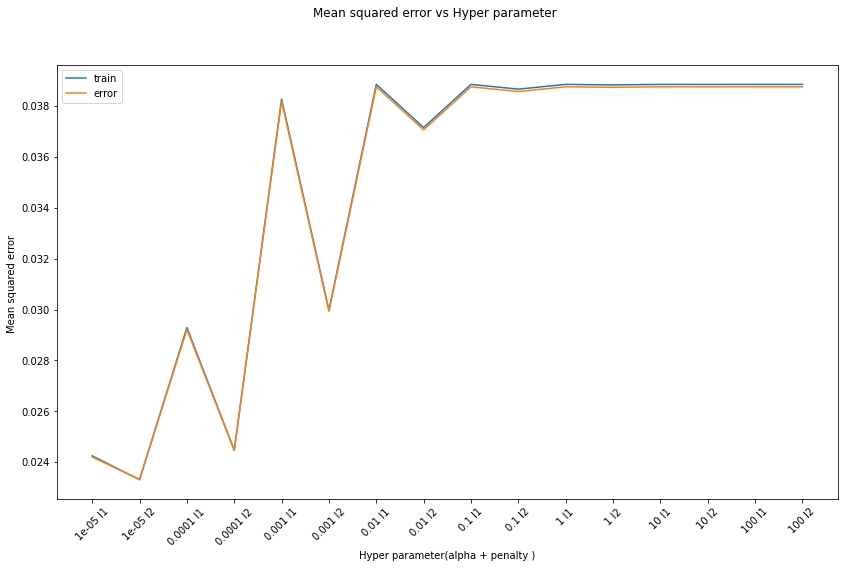

In [54]:
plt.figure(figsize=(14, 8))
plt.plot(range(len(alpha) * len(penalty) ), train_errors)
plt.plot(range(len(alpha) * len(penalty)), val_errors)
plt.suptitle("Mean squared error vs Hyper parameter")
plt.legend(['train', 'error'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyper parameter(alpha + penalty )')
plt.ylabel("Mean squared error ")
plt.show()

Coefficient of features

In [55]:
feat_names = tfidf.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,1.662962
idiot,1.349494
fool,0.719637
dumb,0.650455
pathet,0.647509
ignor,0.640464
moron,0.630047
ridicul,0.616169
loser,0.611866
crap,0.564682


Decision tree on tfidf

In [56]:
max_depth = [3, 5, 7]
min_samp = [10, 100, 1000]
train_errors = []
val_errors = []

best_model = None
best_error = 10
xticks = []

for d in max_depth:
  for s in min_samp:
    dt = DecisionTreeRegressor(max_depth = d, min_samples_leaf = s)
    dt.fit(train_message_tfidf, train_target)

    pred = dt.predict(train_message_tfidf) 
    print("max_depth : ", d, "  min_samples : ", s)
    xticks.append(str(d) + ' ' + str(s))
    error = mean_squared_error(pred, train_target)
    print("Train mse : ", error)
    train_errors.append(error)

    pred = dt.predict(val_message_tfidf) 
    error = mean_squared_error(pred, val_target)
    print("val mse : ", error)
    val_errors.append(error)

    if error < best_error:
      best_model = dt
      best_error = error
      print('*'*30)

max_depth :  3   min_samples :  10
Train mse :  0.032893383142755014
val mse :  0.0329780759582974
******************************
max_depth :  3   min_samples :  100
Train mse :  0.03289338314275501
val mse :  0.03297807595829741
max_depth :  3   min_samples :  1000
Train mse :  0.03289338314275501
val mse :  0.0329780759582974
max_depth :  5   min_samples :  10
Train mse :  0.03175271248371392
val mse :  0.03184725742759621
******************************
max_depth :  5   min_samples :  100
Train mse :  0.03175334465859473
val mse :  0.03184750106504676
max_depth :  5   min_samples :  1000
Train mse :  0.03176365000992346
val mse :  0.031856899840253916
max_depth :  7   min_samples :  10
Train mse :  0.03074527007929329
val mse :  0.030806640383263837
******************************
max_depth :  7   min_samples :  100
Train mse :  0.03076115734739212
val mse :  0.030809051803829788
max_depth :  7   min_samples :  1000
Train mse :  0.030802795746617692
val mse :  0.030840807547190326


Best model

In [57]:
preds = best_model.predict(train_message_tfidf) # Get predictions
err = mean_squared_error(train_target, preds) # Calculate error on trainset
print("Mean Squared Error on train set: ", err)
        
preds = best_model.predict(val_message_tfidf) # Get predictions on CV set
err = mean_squared_error(val_target, preds) # Calculate error on cv set
print("Mean Squared Error on cv set: ", err)

Mean Squared Error on train set:  0.03074527007929329
Mean Squared Error on cv set:  0.030806640383263837


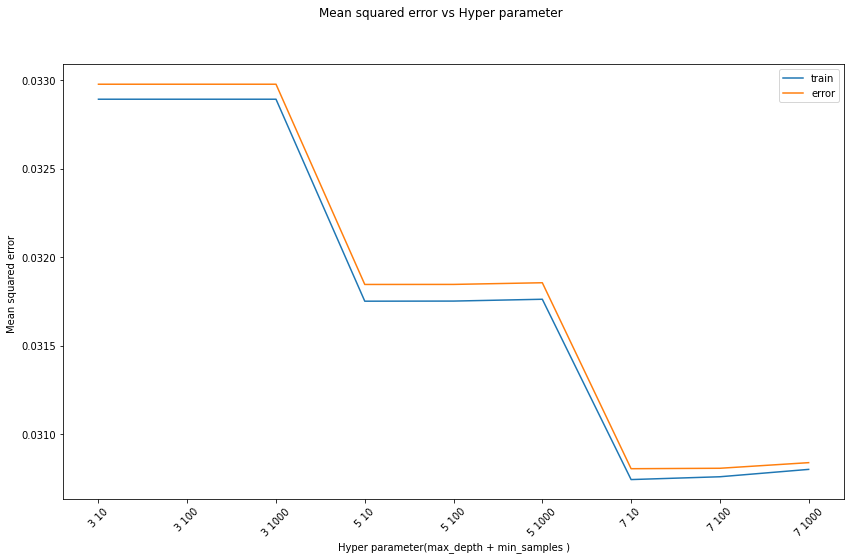

In [58]:
plt.figure(figsize=(14, 8))
plt.plot(range(len(max_depth) * len(min_samp) ), train_errors)
plt.plot(range(len(max_depth) * len(min_samp)), val_errors)
plt.suptitle("Mean squared error vs Hyper parameter")
plt.legend(['train', 'error'])
plt.xticks(range(len(max_depth) * len(min_samp)), xticks, rotation=45)
plt.xlabel('Hyper parameter(max_depth + min_samples )')
plt.ylabel("Mean squared error ")
plt.show()

top 20 feature with Feature importance 

In [59]:
feat_names = cv.get_feature_names()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.405929
idiot,0.267119
fool,0.072306
pathet,0.070156
moron,0.064302
white,0.057567
dumb,0.053222
racist,0.005372
fool peopl,0.000886
ignor,0.000841


Here best model from all model is : SGD regressor with tfidf vectorization method

and

Mean Squared Error on train set:  0.023313194856301823

Mean Squared Error on cv set:  0.023324606373848766